# Extract tweet and calculate the polarity of tweets in a specific location

### Firstly, import library needed

In [1]:
# import the library used
import tweepy
import json
from textblob import TextBlob
from datetime import datetime
import pytz
import tweepy
import re
import pandas as pd

# authenticating twitter api credentials
consumer_key="hwA6Ck29A1eIJaPgwdsdBla5d"
consumer_secret="iWq0IYx48CKK4fEuqUkA4CnX0Jgk2BUqwgR9lzlxGjScILJ2Gc"
access_token="100953017-rss1HLCwmx3YCVnA8iBmIOXimDytqp6XJ2Xttlql"
access_token_secret="SnHgjq3RCyQMiB8Ay7htijrKUeNLDX01g0uQxqrJ67WZQ"

# instantiating the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# creating API object
api = tweepy.API(auth, wait_on_rate_limit=True)

# Function that convert timestamop of each tweet to NY time 
def convert_to_nyc_time(timestamp):
    nyc_timezone = pytz.timezone("America/New_York")

    # Convert the UTC time to New York local time
    nyc_time = timestamp.astimezone(nyc_timezone)
    return nyc_time



### Function that extract twitter:
Input: latitude, longtitude of twitter, radius of twitter, number of tweet we want to extract, radius of twitter around the location and search query, we can also define min retweet and min favorite if we want to select only populat tweets <br>
Output: a Dataframe that show all the tweet and timestamps

In [2]:
def get_tweet(latitude, longitude,max_tweets, location_radius = "10km", search_query ="", min_retweet=0,min_fav=0):
    tweets_per_request = 100
    geocode = f"{latitude},{longitude},{location_radius}"
    tweets = []
    last_id = None
    while len(tweets) < max_tweets:
        search_results = api.search_tweets(q=search_query, lang="en", tweet_mode="extended", geocode=geocode, count=tweets_per_request, max_id=last_id)
        if not search_results:
            break
        tweets.extend(search_results)
        last_id = search_results[-1].id - 1

    min_retweets = 0
    min_fav = 0

    filtered_tweets = []

    for tweet in tweets:
        if tweet.full_text[0] != '@' and tweet.retweet_count >= min_retweets and tweet.favorite_count >= min_fav:
            # Remove URLs from the tweet text
            cleaned_text = re.sub(r'http\S+|www.\S+', '', tweet.full_text)

            # Create a new tweet object with the cleaned text
            cleaned_tweet = tweepy.models.Status()
            cleaned_tweet.__dict__ = tweet.__dict__.copy()
            cleaned_tweet.full_text = cleaned_text

            filtered_tweets.append(cleaned_tweet)
    tweet_content = []
    tweet_time = []
    for tweet in filtered_tweets:
        nyc_time = convert_to_nyc_time(tweet.created_at)
        tweet_content.append(tweet.full_text)
        tweet_time.append(nyc_time)
    df_tweet = pd.DataFrame({'time':tweet_time, 'content':tweet_content})
    return df_tweet

# Example, 
tweet around Cornell tech Campus (40.757929, -73.956376) with key word "Cornell"

In [3]:
df = get_tweet(40.757929, -73.956376 ,1000, location_radius = "10km", search_query ="Cornell", min_retweet=0,min_fav=0)
df.head(5)

KeyboardInterrupt: ignored

In [ ]:
df.tail()

,time,content
232,2023-04-14 21:21:29-04:00,A Cornell University student drafted a resolut...
233,2023-04-14 18:14:17-04:00,on #rooseveltisland Gorgeous Photo Of First 20...
234,2023-04-14 17:43:22-04:00,\nThe Florida Department of Law Enforcement ha...
235,2023-04-14 17:17:07-04:00,"""Demand for home health aides is soaring. So w..."
236,2023-04-14 15:42:45-04:00,Cornell Notes Notebook\nPrice: $4.39\n\n.\n.\n...


# Analysing sentiment using TextBlob
The output from the sentiment analysis is a named tuple of the form (polarity, subjectivity), where polarity is a float between -1 and 1 representing the sentiment polarity (negative to positive) and subjectivity is a float between 0 and 1 representing the subjectivity of the text (0 means very objective, and 1 means very subjective).


In [4]:
def sentiment_analysis(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Perform sentiment analysis
    sentiment = blob.sentiment
    polarity_score = sentiment.polarity
    subjectivity_score = sentiment.subjectivity
    return (polarity_score, subjectivity_score)


## For example

In [5]:
sentiment_analysis("this place is the best")

(1.0, 0.3)

In [6]:
sentiment_analysis("this place is the worst")

(-1.0, 1.0)

# Evaluate neighborhood
The function below will calculate the average polarity of every tweet in the dataframe

In [7]:
def average_polarity(df):
    if len(df) == 0:
      return (0,0)
    else:
      total_value = 0
      # Iterate over the content column and apply the content_to_value function
      for content in df["content"]:
          total_value += sentiment_analysis(content)[0]
      average_value = total_value / len(df)
      return (average_value, len(df))

# Example

In [ ]:
df = get_tweet(40.757929, -73.956376 ,1000, location_radius = "10km", search_query ="Cornell", min_retweet=0,min_fav=0)
print(average_polarity(df))

(0.17933543447586167, 237)


## Create table of location , longtitude, latitude

In [8]:
import urllib.request
import json
import math

url = 'https://data.cityofnewyork.us/resource/xyye-rtrs.json'

# Fetch the data from the URL
with urllib.request.urlopen(url) as url:
    data = json.loads(url.read().decode())
coordinates_to_neighborhood = {}
for neighborhood in data:
    if neighborhood['borough'] == "Manhattan":
        lat = neighborhood['the_geom']['coordinates'][1]
        lon = neighborhood['the_geom']['coordinates'][0]
        coordinates_to_neighborhood[tuple([lat, lon])] = neighborhood['name']
len(coordinates_to_neighborhood)

39

In [9]:
coordinates_to_neighborhood

{(40.87655077879968, -73.91065965862988): 'Marble Hill',
 (40.715618422314364, -73.99427936255985): 'Chinatown',
 (40.85190252555309, -73.93690027985242): 'Washington Heights',
 (40.86768396449919, -73.92121042203905): 'Inwood',
 (40.82360428481197, -73.94968791883373): 'Hamilton Heights',
 (40.81693442949784, -73.95738539351888): 'Manhattanville',
 (40.81597606742418, -73.94321112603912): 'Central Harlem',
 (40.79224946663037, -73.94418223148531): 'East Harlem',
 (40.77563857330185, -73.96050763135007): 'Upper East Side',
 (40.77592984988492, -73.94711784471833): 'Yorkville',
 (40.76811265828737, -73.95885968813766): 'Lenox Hill',
 (40.762403730702246, -73.9494705736962): 'Roosevelt Island',
 (40.7876579985349, -73.9770592363061): 'Upper West Side',
 (40.773528889421705, -73.9853377700127): 'Lincoln Square',
 (40.758333686906404, -73.99640768221386): 'Clinton',
 (40.75469110270627, -73.98166882730311): 'Midtown',
 (40.74830307725222, -73.97833207924134): 'Murray Hill',
 (40.7440347067

In [10]:
neighbor_hood_list = []
sentiment_score = []
number_of_tweet = []
for key, value in coordinates_to_neighborhood.items():
    latitude = key[0]
    longitude = key[1]
    neighborhood = value
    df_tweet = get_tweet(latitude, longitude ,1000, location_radius = "10km", search_query =neighborhood, min_retweet=0,min_fav=0)
    result = average_polarity(df_tweet)
    neighbor_hood_list.append(neighborhood)
    sentiment_score.append(result[0])
    number_of_tweet.append(result[1])
#limit reach, run again tomorrow

In [11]:
df_final = pd.DataFrame({'neighborhood':neighbor_hood_list, 'sentiment':sentiment_score, 'number_of_tweet':number_of_tweet })
df_final

,neighborhood,sentiment,number_of_tweet
0,Marble Hill,0.018519,9
1,Chinatown,0.061016,233
2,Washington Heights,0.165812,5
3,Inwood,0.040000,20
4,Hamilton Heights,0.256494,7
5,Manhattanville,0.256120,14
6,Central Harlem,0.164500,32
7,East Harlem,0.075865,89
8,Upper East Side,0.055214,189
9,Yorkville,0.060417,8


In [12]:
df_final_top_10 = df_final.nlargest(10, 'number_of_tweet')

In [13]:
df_final_top_10

,neighborhood,sentiment,number_of_tweet
17,Chelsea,0.090103,596
14,Clinton,0.094087,496
15,Midtown,0.088349,350
11,Roosevelt Island,0.109923,276
23,Soho,0.094537,262
21,Tribeca,0.150133,251
1,Chinatown,0.061016,233
12,Upper West Side,0.087930,191
8,Upper East Side,0.055214,189
29,Financial District,0.010120,159


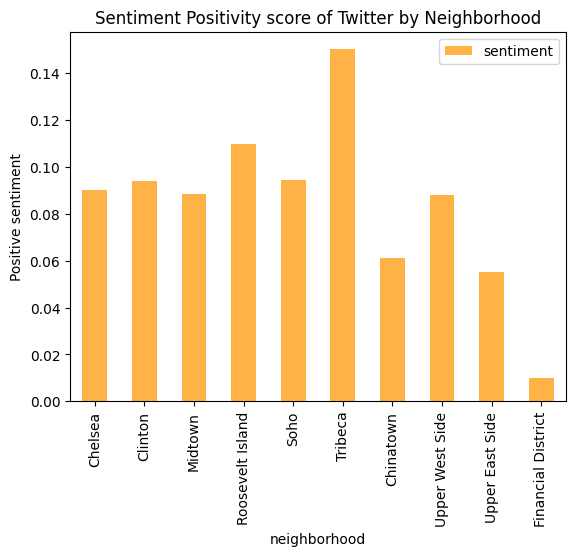

In [34]:
import matplotlib.pyplot as plt
ax = df_final_top_10.plot(kind='bar', x='neighborhood', y='sentiment', rot=0,color='#ffb347')

# set the x and y axis labels
ax.set_xlabel("neighborhood")
ax.set_ylabel("Positive sentiment")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_title("Sentiment Positivity score of Twitter by Neighborhood")
# show the plot
plt.show()

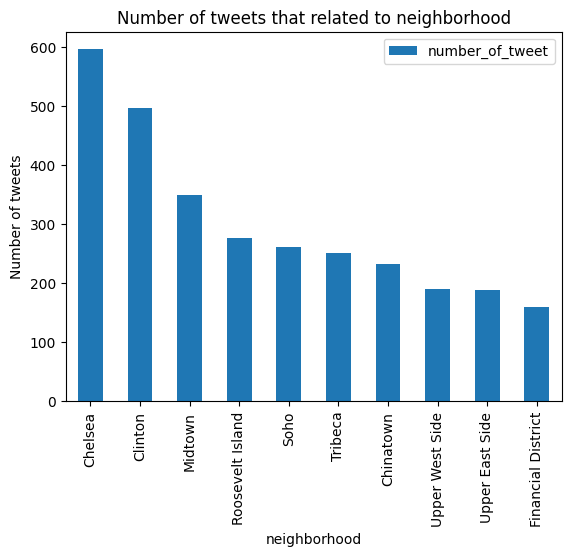

In [32]:
import matplotlib.pyplot as plt
ax = df_final_top_10.plot(kind='bar', x='neighborhood', y='number_of_tweet', rot=0)

# set the x and y axis labels
ax.set_xlabel("neighborhood")
ax.set_ylabel("Number of tweets")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_title("Number of tweets that related to neighborhood")
# show the plot
plt.show()

In [24]:
df_final_top_10

,neighborhood,sentiment,number_of_tweet
17,Chelsea,0.090103,596
14,Clinton,0.094087,496
15,Midtown,0.088349,350
11,Roosevelt Island,0.109923,276
23,Soho,0.094537,262
21,Tribeca,0.150133,251
1,Chinatown,0.061016,233
12,Upper West Side,0.087930,191
8,Upper East Side,0.055214,189
29,Financial District,0.010120,159
